### Binomial Asset Pricing Model
---

The goal of this notebook is to study the binomial asset pricing model and its applicaiton to the pricing of European options i.e. options with a fixed execution date.  Specifically we will compare it to the continuous time Black-Scholes model which is based on geometric brownian motion.  One benefit of this model is that due to its discrete nature it can be more readily used for the pricing of American options which do not have a fixed execution date - a possibility which continuous time models have more issues dealing with.

The main idea behind the binomial asset pricing model is simple.  At each time step the underlying asset price (which we will simply take to be a stock price) has a probability $p$ to be multiplied by a factor $u$ and a probability $q=1-p$ to be multiplied by a factor $d$.  Further, we assume that there is a risk-free intrest rate $r$.

<p align="center">
    <img src="binomial_asset_tree.png" width="400">
</p>
Note that at each step in the tree the distribution of possible prices is a random variable following a binomial distribution.

In order for the model to have no arbitrage opportunities one must have
$$
0 < d <1+r < u
$$
otherwise it can be shown that one can create a portfolio $X$ at time $t=0$ which only increases by some later time step.  This can be understood intuitively by setting $r=0$ when it is simply the requirement that the two possibilities for the asset price are that it either increases or decreases but not both.  Taking nonzero $r$ is the adaptation of this to say the asset either grows more or less than intrest.  This is reasonably named the no-arbitrage condition.  Given this conditions one can also change the probability measure $(p,q)$ to the *risk-neutral probability measure* $(\~{p},\~{q})$ defined as 
\begin{align*}
    \~{p} &= \frac{1+r-d}{u-d},\\
    \~{q} &= \frac{u-1-r}{u-d}.
\end{align*}
These are the probabilities such that the expectation value of the asset price at time $t_{i+1}$ acts as if you had simply taken the risk-free intrest rate at time $t_i$

$$\~{\mathbb{E}}[S_{t_{i+1}}]=(1+r)S_{t_i}.$$

This turns the discounted asset price process into a martingale.  While this is not a realistic description of most asset prices, the purpose of this model is to price derivatives based on the asset price.  Thus, as is the case in Black-Scholes, we are more interested in these risk-neutral probabilities as they are what applies to hedging ones position effectively when buying and selling options.

Note that we are assuming the intrest is compounded at each step in the binomial tree which is why the multiplicative factor is $(1+r)$.  What we will move to in the next paragraph is a situation where the intrest is continuously compounded over a time $T$ with $N$ steps in the tree in which case we would make the following replacement in the above discussion:

$$(1+r)\longrightarrow e^{rT/N}.$$


One way of implementing the above description is as follows.  We define the following values:

* $\sigma$ - Volatility of the asset price.
* $T$ - Time to calculate the asset price at.
* $N$ - Number of steps one wants to implement. It is also the height of the binomial tree at time T.

We can then define the necessary binomial variables as follows
\begin{align*}
    u &= e^{\sigma\sqrt{T/N}},\\
    d &= e^{-\sigma\sqrt{T/N}},\\
    \~{p} &= \frac{e^{rT/N}-d}{u-d}.
\end{align*}

In doing this we have rephrased the binomial model in terms of concepts which are similar to those which appear in Black-Scholes model.  We will now implement this to generate stock paths and then discuss the exact computation of options prices.  Note that we have taken $d=1/u$  This is not strictly necessary but it is done for convenience to limit the number of variables involved since one can always generate risk-neutral probabilities under the no-arbitrage condition given above.  We have also given the risk-neutral probability, this is what we will use in the model and we will include more realistic probabilities by adding a drift term $\mu$ to $\~{p}$ which will turn the process into a sub- or super- martingale based on the sign of $\mu$.

As an aside I also note that $\sigma$ is only the same as the standard deviation of the log returns of this binomial model in the large $N$ limit.  If the probabilities are $(p,q)$ then the standard deviation of the log returns at time $T$ is
$$
\sigma_{\text{ln}(S_T)} = 2\sigma \sqrt{pq}
$$
Now, if we take the risk-neutral probabilities, we have that for large $N$ 
$$\lim_{N\rightarrow\infty}\~{p} = 1/2$$
and so 
$$\lim_{N\rightarrow\infty}\sigma_{\text{ln}(S_T)} = \sigma$$
In other words, since we know the large $N$ limit of the binomial distribution is a normal distribution, the large $N$ limit of the binomial model defined this way is the log-normal model with standard deviation $\sigma$.  Any value of $u$ (so long as $d=1/u$) will act this way, but defining things this way allows us to control the large $N$ standard deviation.


In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as stats
from collections import defaultdict

sns.set_style('darkgrid')

In [445]:
def binomial_stock_path(S0,sigma,r,T,N,n_paths,mu=0.0):
    '''
    Returns a series of N + 1 stock values from t=0 to t=T.
    
    S0 - initial stock price.
    T - time the price path is determined til.
    N - number of steps in the tree.
    sigma - volatility used to define the multiplicative factor at each branch u = e^(sigma*sqrt(T/N))
    r - risk-free intrest rate available in the money market.
    n_paths - number of stock paths to be simulated.
    mu - drift term set to 0 by default.  Causes the paths to tend upward or downward depending on its sign. Must have that mu + ~p < 1
    '''
    
    dt = T/N
    u = np.exp(sigma*np.sqrt(dt))
    d = 1/u
    p = (np.exp(r*dt) - d)/(u-d) + mu/(2*N*sigma*np.sqrt(dt))
    if not 0 < d < np.exp(r*dt) < u:
        print('Error: The model with these settings does not satisfy the no-arbitrage condition')
        return None
    if p > 1 or p < 0:
        print(f'Error: Chosen probability is not between 0 and 1. p = {p}')
        return None
    print(f'u-factor: {u}')
    print(f'd-factor: {1/u}')
    exponents = np.cumsum((np.random.binomial(1,p,(n_paths,N))*2) - 1, axis=1)
    exponents = np.insert(exponents,0,0,axis=1)
    stock_path = S0*u**exponents
    
    return stock_path
    

u-factor: 1.0158731811967918
d-factor: 0.9843748398022558


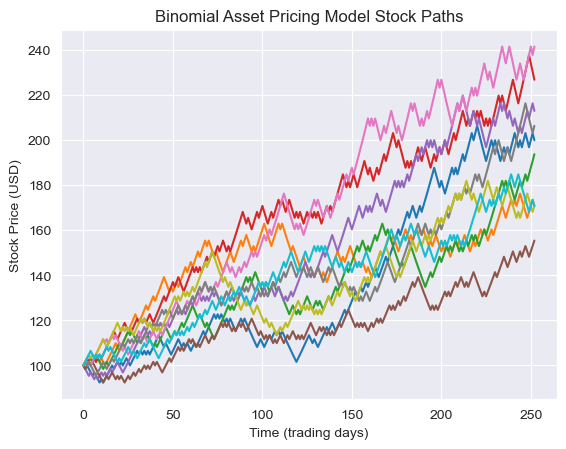

In [446]:
S0 = 100
sigma = .25
r = 0.04
T = 1
N = 252
n_paths = 10
mu = 0.5
paths = binomial_stock_path(S0,sigma,r,T,N,n_paths,mu=mu)
for path in paths:
    plt.plot(path)
plt.title('Binomial Asset Pricing Model Stock Paths')
plt.xlabel('Time (trading days)')
plt.ylabel('Stock Price (USD)')
plt.show()

### European Options
---

Now that we are able to simulate the price paths in the binomial model we can discuss the exact pricing of options, how to delta hedge them, and then compare the results to Monte-Carlo simulation using the above paths.

Generically, the price of an European option is the expected value of said option at expiration, discounted back to the time in question.  i.e. if the value of the option at expiration time $T$ is $V_N(S_N)$ then we have

$$
V^E_0(S_0) \stackrel{?}{=} e^{-rT}\mathbb{E}_P[V_N(S_N)]
$$

Where $P$ subscript indicates the probability measure to be used is undecided. The issue of course is computing this expectation value requires knowledge of the real probabilities $(p,q)$, which is something that typically seems like a fool's errand to determine for any measure other than the risk-neutral one.  The point of doing any of this at all is that for our pricing model, if we assume the risk-neutral probabilities it is possible to create a portfolio (updated at each time step) which will mimic the *real* value of the option at expiration. Thus it is appropriate to choose $(\~{p},\~{q})$:

$$
V^E_0(S_0) = e^{-rT}\widetilde{\mathbb{E}}[V^E_N(S_N)].
$$


With the binomial asset pricing model we have a discrete probability distribution of possible prices at each time step and thus we can compute the option price exactly as a function of the models parameters.  A naïve way of doing this is to start from some particular price point and compute all possible stock paths eminating from it in order to determine the distribution of expiration prices and compute the options expectation value.  For a large enough number of steps this idea becomes increasingly untenable because the number of paths grows as $\mathcal{O}(2^n)$.  However, what is not difficult to compute is the set of final values the asset can possibly take in the binomial pricing model; they are labeled by the number of up and down steps alone with the ordering inconsequential to the final price.  Thus, if we are interested in the price distribution $N$ steps in the future we know that a stock which began at $S_0$ can take on the $N+1$ possible values
$$
\{u^NS_0,u^{N-1}dS_0,u^{N-2}d^2S_0,\dots,d^NS_0\}.
$$
Now what is needed is the probability mass function on this distribution in order to compute any expectation value we like.  Luckily since the process generating the stock paths is equivalent to a series of coin flips, we know that the distribution will be the binomial distribution $B(N,p)$.  

We will examine call options at strike price $K$ and expiration $T$ where the value of the option at expiration is $(S_T-K)^+:=\text{max}(S_T-K,0)$.  If $b(k,N,\~{p})$ is the probability mass function for $k$ upmovements and $N-k$ down movements then the value of the European call is
$$
C^E_0 = e^{-rT}\sum_{k=0}^Nb(k,N,\~{p})(S_T-K)^+ = e^{-rT}\sum_{k=0}^Nb(k,N,\~{p})(u^kd^{N-k}S_0-K)^+
$$


In [447]:
def binomial_call_value(S0,K,sigma,r,T,N):
    '''
    Returns the discounted value of a European call option expiring in N periods at time T.
    
    S0 - initial stock price.
    K - strike price of the option
    T - option expiration time.
    N - number of steps in the tree.
    sigma - volatility used to define the multiplicative factor at each branch u = e^(sigma*sqrt(T/N))
    r - risk-free intrest rate available in the money market.
    '''
    
    dt = T/N
    u = np.exp(sigma*np.sqrt(dt))
    d = 1/u
    p = (np.exp(r*dt) - d)/(u-d)
    if not 0 < d < np.exp(r*dt) < u:
        print('Error: The model with these settings does not satisfy the no-arbitrage condition')
        return None
    end_factors = []
    end_probs = []
    for k in range(N+1):
        end_factors += [(u**(k))*(d**(N-k))]
        end_probs += [stats.binom.pmf(k,N,p)]
    end_prices = np.array(end_factors)*S0
    end_call_values = np.fmax(end_prices - K,0.0)
    end_probs = np.array(end_probs)
    discounted_call_value = np.exp(-r*T)*np.sum(end_call_values*end_probs)
    return discounted_call_value



In [448]:
S0 = 100
Ks = [90,95,100,105,110]
sigma = .25
r = 0.05
T = 1
N = 252
print('-'*55)
for K in Ks:
    print(f'The initial price of the call at K = {K} is ${binomial_call_value(S0,K,sigma,r,T,N):.2f}')
    print('-'*55)

-------------------------------------------------------
The initial price of the call at K = 90 is $18.15
-------------------------------------------------------
The initial price of the call at K = 95 is $15.05
-------------------------------------------------------
The initial price of the call at K = 100 is $12.33
-------------------------------------------------------
The initial price of the call at K = 105 is $10.01
-------------------------------------------------------
The initial price of the call at K = 110 is $8.02
-------------------------------------------------------


We can now validate our formula for the call option via Monte Carlo.

In [449]:
S0 = 100
Ks = [90,95,100,105,110]
sigma = .25
r = 0.035
T = 1
N = 252
n_sims = 500_000
print('-'*100)
for K in Ks:
    end_call_value = binomial_stock_path(S0,sigma,r,T,N,n_sims)[:,-1] - K
    end_call_value = np.heaviside(end_call_value,0.0)*end_call_value
    discounted_call_value = np.exp(-r*T)*np.mean(end_call_value)
    print(f'K = {K} simulated call value: ${discounted_call_value:.2f}| theory call value: ${binomial_call_value(S0,K,sigma,r,T,N):.2f}')
    print('-'*100)
    

----------------------------------------------------------------------------------------------------
u-factor: 1.0158731811967918
d-factor: 0.9843748398022558
K = 90 simulated call value: $17.26| theory call value: $17.27
----------------------------------------------------------------------------------------------------
u-factor: 1.0158731811967918
d-factor: 0.9843748398022558
K = 95 simulated call value: $14.23| theory call value: $14.24
----------------------------------------------------------------------------------------------------
u-factor: 1.0158731811967918
d-factor: 0.9843748398022558
K = 100 simulated call value: $11.60| theory call value: $11.58
----------------------------------------------------------------------------------------------------
u-factor: 1.0158731811967918
d-factor: 0.9843748398022558
K = 105 simulated call value: $9.34| theory call value: $9.35
----------------------------------------------------------------------------------------------------
u-factor: 1

The problem of course is that here we have simulated the price movements using the risk-neutral probabilities.  A more realistic scenario is one where the stock has a drift in either direction.  If we simulate stock paths with such a drift we should expect this naïve pricing to fail.  We show a single case here as an example:

In [450]:
S0 = 100
Ks = [95]
sigma = .25
r = 0.035
T = 1
N = 252
n_sims = 1_000_000
mu = 0.1
print('-'*100)
for K in Ks:
    end_call_value = binomial_stock_path(S0,sigma,r,T,N,n_sims,mu=mu)[:,-1] - K
    end_call_value = np.heaviside(end_call_value,0.0)*end_call_value
    discounted_call_value = np.exp(-r*T)*np.mean(end_call_value)
    print(f'K = {K} simulated call value: ${discounted_call_value:.2f}| theory call value: ${binomial_call_value(S0,K,sigma,r,T,N):.2f}')
    print('-'*100)

----------------------------------------------------------------------------------------------------
u-factor: 1.0158731811967918
d-factor: 0.9843748398022558
K = 95 simulated call value: $22.05| theory call value: $14.24
----------------------------------------------------------------------------------------------------


The solution to this problem is the same as in any options-pricing model, we must delta hedge a potfolio so that the portfolio (as a stochastic process) mimics the option.  In the Black-Scholes case this is obtained by looking at the partial derivative 
$$\Delta^{BS}_t:=\frac{\partial V^E(S,T)}{\partial S}\bigg|_t$$
For our model we do not have a continuous dependence on prices and thus we must work with a discrete derivative which is a ratio of differences.  The goal is effectively to determine the price of the option at every node in the binomial tree of asset prices and the correct formula is
$$
\Delta_i := \frac{V^E_{i+1}(uS_i) - V^E_{i+1}(dS_i)}{(u-d)S_i}.
$$
This formula must be implemented recursively from the values of the options at time $T$ which are known.  Our next goal is to implement this recurisve formula to create a function that takes the asset price and the period to return the option value at that node in the tree.  This sounds computationally problematic but in fact it is not, because it depends entirely on ones nodal location and nothing else and thus the number of option prices that must be calculated is the [triangular number](https://en.wikipedia.org/wiki/Triangular_number) $T_{N+1}$ which grows as $\mathcal{O}(n^2)$.  The way we compute the values in the tree is using the following relation deducible by imagining that any node is itself the starting node of the tree:
$$
V^E_i(S_i) = e^{-rT/N}[\~{p}V^E_{i+1}(uS_i)+\~{q}V^E_{i+1}(dS_i)].
$$

In [451]:
def binomial_call_tree(S0,K,sigma,r,T,N):
    '''
    Returns the tree of binomial call option values as a dictionary with keys (period,number of up movements).
    
    S0 - initial stock price.
    K - strike price of the option.
    T - option expiration time.
    N - number of steps in the tree.
    sigma - volatility used to define the multiplicative factor at each branch u = e^(sigma*sqrt(T/N))
    r - risk-free intrest rate available in the money market.
    '''
    
    dt = T/N
    u = np.exp(sigma*np.sqrt(dt))
    d = 1/u
    p = (np.exp(r*dt) - d)/(u-d)
    if not 0 < d < np.exp(r*dt) < u:
        print('Error: The model with these settings does not satisfy the no-arbitrage condition')
        return None
    end_factors = []
    end_probs = []
    for k in range(N+1):
        end_factors += [(u**(k))*(d**(N-k))]
        end_probs += [stats.binom.pmf(k,N,p)]
    end_prices = np.array(end_factors)*S0
    end_call_values = np.fmax(end_prices - K,0.0)
    call_values = defaultdict(float)
    for k, v in enumerate(end_call_values):
        call_values[(N,k)] = float(v)
    period = N-1
    while period >= 0:
        for k in range(period+1):
            call_values[(period,k)] = float(np.exp(-r*dt)*((1-p)*call_values[(period+1,k)]+p*call_values[(period+1,k+1)]))
        period -= 1
    return call_values
    

In [452]:
#checking that the initial node in the tree (0,0) agrees with our previous function for the call value at this node
S0 = 100
K = 95
sigma = .25
r = 0.05
T = 1
N = 252
call_tree = binomial_call_tree(S0,K,sigma,r,T,N)
print(f'The call value taking the discounted expectation value is: ${binomial_call_value(S0,K,sigma,r,T,N):.2f}')
print(f'The call value by looking at the (0,0) node of the tree is: ${call_tree[(0,0)]:.2f}')


The call value taking the discounted expectation value is: $15.05
The call value by looking at the (0,0) node of the tree is: $15.05


In [453]:
def binomial_call_delta(Si,i,K,sigma,r,T,N):
    '''
    Returns the appropriate Delta hedge given the price at that node and the period it is on (along with other relevant parameters).
    
    Si - stock price at the current node.
    i - the period that one is currently on, i.e. the multiple of T/N
    K - strike price of the option
    T - option expiration time.
    N - number of steps in the tree.
    sigma - volatility used to define the multiplicative factor at each branch u = e^(sigma*sqrt(T/N))
    r - risk-free intrest rate available in the money market.
    '''
    
    dt = T/N
    u = np.exp(sigma*np.sqrt(dt))
    d = 1/u
    if not 0 < d < np.exp(r*dt) < u:
        print('Error: The model with these settings does not satisfy the no-arbitrage condition')
        return None
    call_tree = binomial_call_tree(Si,K,sigma,r,dt*(N-i),N-i)
    #print(call_tree)
    delta = (call_tree[(1,1)]-call_tree[(1,0)])/((u-d)*Si)
    return delta

def binomial_call_delta_tree(S0,K,sigma,r,T,N):
    '''
    Returns the call Delta for each node in the binomial asset price tree.
    
    S0 - initial stock price.
    K - strike price of the option
    T - option expiration time.
    N - number of steps in the tree.
    sigma - volatility used to define the multiplicative factor at each branch u = e^(sigma*sqrt(T/N))
    r - risk-free intrest rate available in the money market.
    '''
    dt = T/N
    u = np.exp(sigma*np.sqrt(dt))
    d = 1/u
    call_tree = binomial_call_tree(S0,K,sigma,r,T,N)
    delta_tree = defaultdict(float)
    for n in range(N):
        for k in range(n+1):
            S = S0*u**(k)*d**(n-k)
            delta_tree[(n,k)] = (call_tree[(n+1,k+1)]-call_tree[(n+1,k)])/((u-d)*S)
    return delta_tree

With these funcitons we have everything we need to test the hedging ability of this model.  To showcase this we define our portfolio value at each time step to be 
$$
X_{i+1} = S_{i+1}\Delta_i + e^{rT/N}(X_{i}-\Delta_iS_i)
$$
We will take $X_0$ to be whatever we sell the option for at the beginning of the process.  Typically, this will be the value of an option with a slightly higher sigma than the one we will model the stock at in order to simulate the premium of the market maker.

In [454]:

def tree_coordinate_path(stock_paths):
    ''' 
    Turns an array of stock paths into an array of position paths in the binomial tree labeled by (period,num_heads)
    '''    
    num_periods = np.shape(stock_paths)[1]
    num_paths = np.shape(stock_paths)[0]
    coordinate_paths = []
    for stock_path in stock_paths:
        coordinate_path = [(0,0)]
        for period in range(1,num_periods):
            prev_coord = coordinate_path[-1][1]
            Si = stock_path[period]
            Sp = stock_path[period-1]
            if Si > Sp:
                coordinate_path += [(period,prev_coord+1)]
            else:
                coordinate_path += [(period,prev_coord)]
        coordinate_paths.append(coordinate_path)
    return np.array(coordinate_paths)   
    

u-factor: 1.0158731811967918
d-factor: 0.9843748398022558


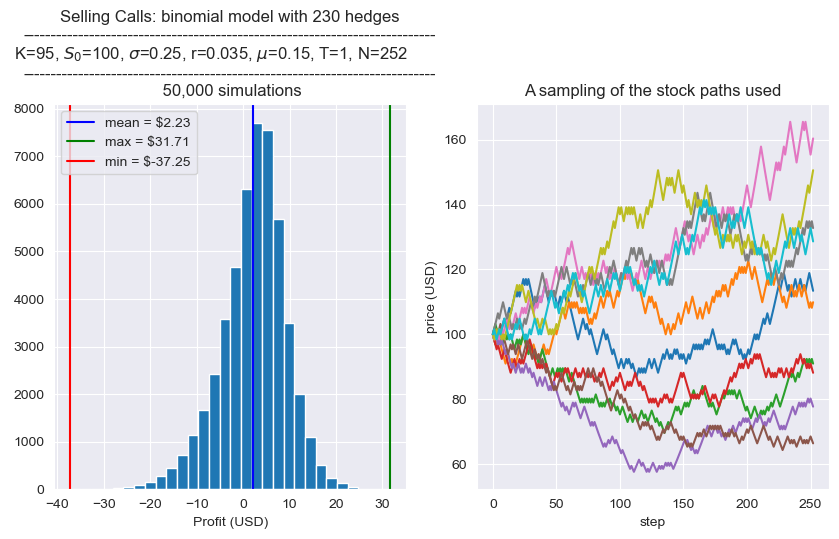

Premium being charged: $3.61
Stock price changed by $20.44 on average


In [455]:
S0 = 100
K = 95
sigma = .25
r = 0.035
T = 1
N = 252
n_sims = 50_000
mu=0.15
paths = binomial_stock_path(S0,sigma,r,T,N,n_sims,mu=mu)
coord_paths = tree_coordinate_path(paths)
deltas = binomial_call_delta_tree(S0,K,sigma, r, T, N)

delta_paths = np.array([[float(deltas[tuple(coord)]) for coord in path] for path in coord_paths])


#The initial value of the portfolio is that of a slightly higher sigma to account for premium.
X = np.full((1,n_sims),binomial_call_value(S0,K,sigma+.1,r,T,N))

#I have chosen not to hedge at each step in the tree as the profit distribution will be unrealistically perfect.
#Instead I have chosen to hedge for some number of steps less than N.
num_hedges = 230
hedge_steps = [int(i) for i in np.array(list(range(N)))*N/num_hedges if int(i) <= N-1]
hedge_steps.append(N)

for i,step in enumerate(hedge_steps[:-1]):
    Xnext = np.reshape(delta_paths[:,step]*(paths[:,step+1]-np.exp(r*T/N*(hedge_steps[i+1]-hedge_steps[i]))*paths[:,step])\
                        + np.exp(r*T/N*(hedge_steps[i+1]-hedge_steps[i]))*X[-1],(1,n_sims))
    X = np.append(X,Xnext,axis=0)
    
X = np.transpose(X)
call_payout = np.fmax(paths[:,-1] - K,0.0)
profit = np.around(np.exp(-r*T)*(X[:,-1] - call_payout),2)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10, 5))

ax1.hist(profit,bins=30)
ax1.set_title(f'Selling Calls: binomial model with {num_hedges} hedges\n{'-'*75}\n K={K}, $S_0$={S0}, $\sigma$={sigma}, r={r}, $\mu$={mu}, T={T}, N={N}\
          \n{'-'*75}\n {n_sims:,} simulations')
ax1.axvline(np.mean(profit),c='b',label=f'mean = ${np.mean(profit):.2f}')
ax1.axvline(np.max(profit),c='g',label=f'max = ${np.max(profit):.2f}')
ax1.axvline(np.min(profit),c='r',label=f'min = ${np.min(profit):.2f}')
ax1.legend(loc='best')
ax1.set_xlabel('Profit (USD)')

for path in paths[0::5000,:]:
    ax2.plot(path)
ax2.set_title('A sampling of the stock paths used')
ax2.set_xlabel('step')
ax2.set_ylabel('price (USD)')

plt.show()
print(f'Premium being charged: ${binomial_call_value(S0,K,sigma+.1,r,T,N)-binomial_call_value(S0,K,sigma,r,T,N):.2f}')
print(f'Stock price changed by ${np.mean(paths[:,-1])-S0:.2f} on average')


In the above code I have included a drift term which the risk-neutral option pricing formula doesn't know about and have chosen to hedge some number of times less than the number of steps in the binomial tree.  This is why there is an actual distribution of profits at the end and the mean is not equal to the premium charged in the simulation.  Due to the nature of the binomial pricing model, we *can* perfectly hedge under these assumptions unlike in Black-Scholes where it is impossible to hedge at every real number time between purchase and expiration.

Just to showcase this, I have included below the singular histogram which forms if one makes the number of hedges the same as the number of levels in the tree.

u-factor: 1.0158731811967918
d-factor: 0.9843748398022558


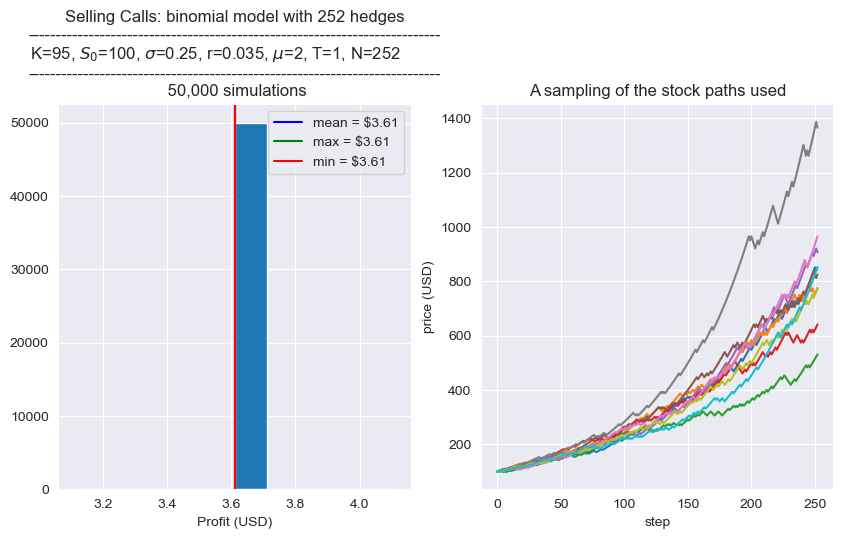

Premium being charged: $3.61
Stock price changed by $659.02 on average


In [459]:

S0 = 100
K = 95
sigma = .25
r = 0.035
T = 1
N = 252
n_sims = 50000
mu=2
paths = binomial_stock_path(S0,sigma,r,T,N,n_sims,mu=mu)
coord_paths = tree_coordinate_path(paths)
deltas = binomial_call_delta_tree(S0,K,sigma, r, T, N)

delta_paths = np.array([[float(deltas[tuple(coord)]) for coord in path] for path in coord_paths])

#The initial value of the portfolio is that of a slightly higher sigma to account for premium.
X = np.full((1,n_sims),binomial_call_value(S0,K,sigma+.1,r,T,N))

#I have chosen not to hedge at each step in the tree as the profit distribution will be unrealistically perfect.
#Instead I have chosen to hedge for some number of steps less than N.
num_hedges = N
hedge_steps = [int(i) for i in np.array(list(range(N)))*N/num_hedges if int(i) <= N-1]
for i in hedge_steps:
    Xnext = np.reshape(delta_paths[:,i]*(paths[:,i+1]-np.exp(r*T/N)*paths[:,i]) + np.exp(r*T/N)*X[-1],(1,n_sims))
    X = np.append(X,Xnext,axis=0)
    
X = np.transpose(X)
call_payout = np.fmax(paths[:,-1] - K,0.0)
profit = np.around(np.exp(-r*T)*(X[:,-1] - call_payout),2)



fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10, 5))

ax1.hist(profit,bins=10)
ax1.set_title(f'Selling Calls: binomial model with {num_hedges} hedges\n{'-'*75}\n K={K}, $S_0$={S0}, $\sigma$={sigma}, r={r}, $\mu$={mu}, T={T}, N={N}\
          \n{'-'*75}\n {n_sims:,} simulations')
ax1.axvline(np.mean(profit),c='b',label=f'mean = ${np.mean(profit):.2f}')
ax1.axvline(np.max(profit),c='g',label=f'max = ${np.max(profit):.2f}')
ax1.axvline(np.min(profit),c='r',label=f'min = ${np.min(profit):.2f}')
ax1.legend(loc='best')
ax1.set_xlabel('Profit (USD)')

for path in paths[0::5000,:]:
    ax2.plot(path)
ax2.set_title('A sampling of the stock paths used')
ax2.set_xlabel('step')
ax2.set_ylabel('price (USD)')

plt.show()
print(f'Premium being charged: ${binomial_call_value(S0,K,sigma+.1,r,T,N)-binomial_call_value(S0,K,sigma,r,T,N):.2f}')
print(f'Stock price changed by ${np.mean(paths[:,-1])-S0:.2f} on average')



We can see that even with an absurdly high drift term where the stock increased by several multiple over the period the option was held we can completely hedge our portfolio (up to numerical error).  This is a unique feature of grid/lattice based pricing models that isn't possible when simulating with continuous models.

Below I have included a set of classes which make the above calculations much cleaner and easier to do.  The first class "binomial_model" takes the model parameters to create an object which can be called with various methods to generate recombining trees associated with the model i.e. the price tree, call value tree, call delta tree etc.  The second class, "binomial_path_sample" takes a defined binomial_path object as well as a desired number of simulations.  Using this information it generates coordinate paths through an abstract recombining binomial tree which can then be applied to various objects to obtain samples of the random variables on the space of paths.  Included in the classes are European put options as well which I didn't cover in the above notebook due to their being a simple adjustment to the calls discussed.

In [457]:
class binomial_model:
    ''' 
        Instantiates a version of the binomial model with the following parameters.
        
        sigma - standard deviation of the log-normal returns at the final period
        r - risk-free interest rate available in the money markets.
        T - time up to which the model is calculated in chosen units.
        N - number of periods beyond the initial node to be generated in the model
        
        example: the initial node is T=0 and you want to generate a years worth of possible paths with the stock priced on each trading day
                 then you would use N=252 T=1.
    '''
    def __init__(self,sigma,r,T,N):
        
        self.sigma = sigma
        self.r = r
        self.T = T
        self.N = N
        
        dt = (self.T)/(self.N)
        self.u = float(np.exp(self.sigma*np.sqrt(dt)))
        self.d = 1/self.u
        self.p_neutral = float((np.exp(self.r*dt)-self.d)/(self.u-self.d))
        self.q_neutral = 1 - self.p_neutral
        
        if not 0 < self.d < np.exp(self.r*dt) < self.u:
            raise ValueError(f'The model with these settings does not satisfy the no-arbitrage condition 0 < d < exp(rT) < u')

    def price_tree(self,S0):
        ''' 
        Returns the tree of stock prices as a dictionary
        
        S0 - initial stock price.
        '''
        dt = self.T/self.N
        u = np.exp(self.sigma*np.sqrt(dt))
        d = 1/u
        
        
        prices = {(n,k):float(S0*u**k*d**(n-k)) for n in range(self.N+1) for k in range(n+1)}
        return prices
    

    def call_option_tree(self,S0,K):
        '''
        Returns the tree of binomial call option values as a dictionary with keys (period,number of up movements).
        
        S0 - initial stock price.
        K - strike price of the option
        '''
        
        dt = self.T/self.N
        u = np.exp(self.sigma*np.sqrt(dt))
        d = 1/u
        p = (np.exp(self.r*dt) - d)/(u-d)
        
        end_factors = [(u**(k))*(d**(self.N-k)) for k in range(self.N+1)]
        
        end_prices = np.array(end_factors)*S0
        end_call_values = np.fmax(end_prices - K,0.0)
        call_values =  defaultdict(float,[((self.N,k), float(v)) for k, v in enumerate(end_call_values)])
    
        #The for loop here seems to be a necessary evil due to the self-referential nature of the tree. i.e. the recursive definition of the option value.
        for period in range(self.N-1,-1,-1):
            for k in range(period+1):
                call_values[(period,k)] = float(np.exp(-self.r*dt)*((1-p)*call_values[(period+1,k)]+p*call_values[(period+1,k+1)]))
        return call_values
    
    def put_option_tree(self,S0,K):
        '''
        Returns the tree of binomial put option values as a dictionary with keys (period,number of up movements).
        
        S0 - initial stock price.
        K - strike price of the option
        '''
        
        dt = self.T/self.N
        u = np.exp(self.sigma*np.sqrt(dt))
        d = 1/u
        p = (np.exp(self.r*dt) - d)/(u-d)
        
        end_factors = [(u**(k))*(d**(self.N-k)) for k in range(self.N+1)]
        
        end_prices = np.array(end_factors)*S0
        end_put_values = np.fmax(K - end_prices,0.0)
        put_values =  defaultdict(float,[((self.N,k), float(v)) for k, v in enumerate(end_put_values)])
    
        #The for loop here seems to be a necessary evil due to the self-referential nature of the tree. i.e. the recursive definition of the option value.
        for period in range(self.N-1,-1,-1):
            for k in range(period+1):
                put_values[(period,k)] = float(np.exp(-self.r*dt)*((1-p)*put_values[(period+1,k)]+p*put_values[(period+1,k+1)]))
        return put_values
        
    def call_delta_tree(self,S0,K):
        '''
        Returns the call Delta for each node in the binomial asset price tree.
        
        S0 - initial stock price.
        K - strike price of the option
        '''
        dt = self.T/self.N
        u = np.exp(self.sigma*np.sqrt(dt))
        d = 1/u
        call_tree = self.call_option_tree(S0,K)
        delta_tree = {(n,k):float((call_tree[(n+1,k+1)]-call_tree[(n+1,k)])/((u-d)*S0*u**(k)*d**(n-k))) for n in range(self.N) for k in range(n+1)}
        return delta_tree
    
    def put_delta_tree(self,S0,K):
        '''
        Returns the put Delta for each node in the binomial asset price tree.
        
        S0 - initial stock price.
        K - strike price of the option
        '''
        dt = self.T/self.N
        u = np.exp(self.sigma*np.sqrt(dt))
        d = 1/u
        put_tree = self.put_option_tree(S0,K)
        delta_tree = {(n,k):float((put_tree[(n+1,k+1)]-put_tree[(n+1,k)])/((u-d)*S0*u**(k)*d**(n-k))) for n in range(self.N) for k in range(n+1)}
        return delta_tree
    
    def initial_call_price(self,S0,K):
        ''' 
        Gives the call price at time t=0.
        
        S0 - initial stock price.
        K - strike price of the option
        '''
        
        calls = self.call_option_tree(S0,K)
        return calls[(0,0)]
    
    def initial_put_price(self,S0,K):
        ''' 
        Gives the put price at time t=0.
        
        S0 - initial stock price.
        K - strike price of the option
        '''
        
        puts = self.put_option_tree(S0,K)
        return puts[(0,0)]


class binomial_path_sample:
    ''' 
    Generates a random sampling of stock paths for a given binomial model. Takes the following inputs:
    
    n_paths - number of price paths to generate in the given model.
    model - a binomial_model class parameterized by sigma,r,T,N.
    mu - optional parameter which causes the paths to be skewed up or down.
    '''
    def __init__(self,n_paths,model,mu=0.0):
        if not isinstance(model, binomial_model):
            raise ValueError('"model" input must be a class of type "binomial_model"')
        self.model = model
        self.n_paths = n_paths
        self.mu = mu
        self.paths = self.gen_path()
        
    def gen_path(self):
        ''' 
        Generates n_paths of length N+1 consisting of positive and negative numbers equal to #u-#d which is the exponent of the overall factor of u multiplying S0.
        '''
        #parameters from the model
        sigma = self.model.sigma
        r = self.model.r
        N = self.model.N
        T = self.model.T
        mu = self.mu
        
        #variables to be used in the method
        dt = T/N
        u = np.exp(sigma*np.sqrt(dt))
        d = 1/u
        n_paths = self.n_paths
        
        p = (np.exp(r*dt)-d)/(u-d) + mu/(2*N*sigma*np.sqrt(dt))
        
        if p > 1 or p < 0:
            raise ValueError(f'Error: Chosen mu = {mu} causes the probability to lie outside [0,1]: p = {p}')
        
        random_path = np.random.binomial(1,p,(n_paths,N))
        
        coordinate_path = np.cumsum(random_path*2 -1, axis=1)
        coordinate_path = np.insert(coordinate_path,0,0,axis=1)
        
        return coordinate_path 

    def price(self,S0):
        ''' 
        Returns a (n_paths, N+1) sized array n_paths price paths corresponding to the paths stored in the object.
        '''
        
        dt = self.model.T/self.model.N
        u = np.exp(self.model.sigma*np.sqrt(dt))
        
        price_paths = S0*(u**self.paths)
            
        return price_paths
    
    def call_delta(self,S0,K):
        '''
        Returns a (n_path, N sized array of the appropriate Delta hedges to take at each step for the paths stored in the path object.)
        '''
        
        #taking the #u-#d path form and turning it into paths which track the total number of ups as this is how the trees are keyed
        node_paths = self.paths.copy()
        node_paths[:,1:] -= node_paths[:,:-1] - 1
        node_paths = np.cumsum(node_paths//2,axis=1)
        
        tree = self.model.call_delta_tree(S0,K)
        
        delta_paths = np.array([[tree[(n, node)] for n, node in enumerate(path)] for path in node_paths[:,:-1]])
        
        return delta_paths
    
    def put_delta(self,S0,K):
        '''
        Returns a (n_path, N sized array of the appropriate Delta hedges to take at each step for the paths stored in the path object.)
        '''
        
        #taking the #u-#d path form and turning it into paths which track the total number of ups as this is how the trees are keyed
        node_paths = self.paths.copy()
        node_paths[:,1:] -= node_paths[:,:-1] - 1
        node_paths = np.cumsum(node_paths//2,axis=1)
        
        tree = self.model.put_delta_tree(S0,K)
        
        delta_paths = np.array([[tree[(n, node)] for n, node in enumerate(path)] for path in node_paths[:,:-1]])
        
        return delta_paths
    
    def replicating_portfolio_profit(self,S0,K,num_hedges,type,premium=0.0):
        #parameters from the model
        sigma = self.model.sigma
        r = self.model.r
        N = self.model.N
        T = self.model.T
        n_sims = self.n_paths
        
        #variables to be used in the method
        dt = T/N
        
        #check if type was correctly chosen
        if type.upper() == 'CALL':
            delta_paths = self.call_delta(S0,K)
            X = np.full(n_sims,self.model.initial_call_price(S0,K)) + premium 
        elif type.upper() == 'PUT':
            delta_paths = self.put_delta(S0,K)
            X = np.full(n_sims,self.model.initial_put_price(S0,K)) + premium
        else:
            raise ValueError('"type" argument must be either "call" or "put".')
        
        paths = self.price(S0)
        
        #creates an array of approx. evenly space time steps in the tree such that there are num_hedges steps.
        hedge_steps = [int(i) for i in np.array(list(range(N)))*N/num_hedges if int(i) <= N-1]
        hedge_steps.append(N)
        #similar to previous methods I am unsure if I can get rid of this loop due to the recursive nature of X
        
        for i,step in enumerate(hedge_steps[:-1]):
            Xnext = delta_paths[:,step]*(paths[:,step+1]-np.exp(r*T/N*(hedge_steps[i+1]-hedge_steps[i]))*paths[:,step])\
                                + np.exp(r*T/N*(hedge_steps[i+1]-hedge_steps[i]))*X
            X = Xnext
            
    
        
        if type.upper() == 'CALL':
            call_payout = np.fmax(paths[:,-1] - K,0.0)
            profit = np.around(np.exp(-r*T)*(X - call_payout),2)
            return profit
        
        if type.upper() == 'PUT':
            put_payout = np.fmax(K - paths[:,-1],0.0)
            profit = np.around(np.exp(-r*T)*(X - put_payout),2)
            return profit


Just as an example this is the exact same computation being done in the first histogram calculation (but with even more paths) above and we can see it runs *significantly* faster.  Unfortunately the nature of this model makes it slower than Black-Scholes as you are effectively searching a tree rather than using hard coded functions, vectorized code, and arithmetic.

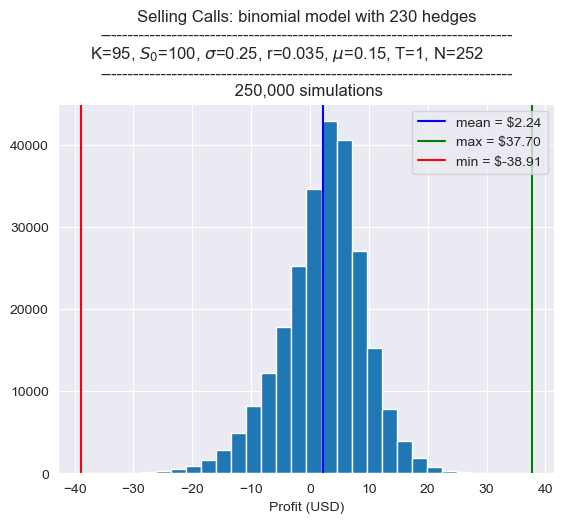

In [460]:
S0 = 100
K = 95
sigma = .25
r = 0.035
T = 1
N = 252
n_paths = 250_000
mu = .15
num_hedges = 230
model = binomial_model(sigma, r, T, N)
sample = binomial_path_sample(n_paths,model,mu)
profit = sample.replicating_portfolio_profit(S0,K,num_hedges,'call',premium=3.61)

plt.hist(profit,bins=30)
plt.title(f'Selling Calls: binomial model with {num_hedges} hedges\n{'-'*75}\n K={K}, $S_0$={S0}, $\sigma$={sigma}, r={r}, $\mu$={mu}, T={T}, N={N}\
          \n{'-'*75}\n {n_paths:,} simulations')
plt.axvline(np.mean(profit),c='b',label=f'mean = ${np.mean(profit):.2f}')
plt.axvline(np.max(profit),c='g',label=f'max = ${np.max(profit):.2f}')
plt.axvline(np.min(profit),c='r',label=f'min = ${np.min(profit):.2f}')
plt.legend(loc='best')
plt.xlabel('Profit (USD)')
plt.show()

### American Options
---

Now we will move on to something new which the binomial model is better suited for than Black-Scholes: pricing American-style options.  The only difference between American and European style options is the American options allow the contract holder to exercise their right to buy or sell an asset at the strike price at any time between the time of purchase and the expiry.  This introduces issues with Black-Scholes because the Black-Scholes differential equation becomes and inequality and no longer has a closed-form solution.  This inequality is essentially caused by the fact that at each time step one must determine whether or not it is optimal to execute the contract i.e. if the equivalent European option is worth less than the difference between the stock and strike prices. The binomial model however has no issue pricing these due to its discrete nature; we can always calculate the price of the option at each time step and determine if it is optimal to excerise at that step or keep the contract.

The discrete nature of the stock paths in the binomial model is very important.  One cannot simply discretize Black-Scholes and use the analytical solutions of the model to hedge as these are no longer valid for discrete time steps and thus will not faithfully reproduce the value of the American options given the models assumptions.  Further, one cannot combine the two ideas and use the discrete recursion formula for pricing options because the asset price tree would be infinitely branched at each node.  Thus, the binomial model (or some other form of discrete model) is well suited for such a question and since it limits to a log-normal distribution as $N\rightarrow\infty$, our results should be reasonable if one is intrested in modeling stocks via geometric brownian motion.

The main idea for pricing is simple.  At each time step we want to determine if it is more valuable to exercise our option than to keep it.  The idea is now to essentially implement the same recurrence relation as we did for the European options. The difference is at each level $n<N$ we check if the *intrinsic value* of the option, i.e. what it would be worth if we exercised it at that moment, is greater than the risk-neutral expected value of it.  As an equation, if our intrinsic value as a function of the stock price is $G(S)$ (which we will assume to be positive semi-definite) then we have
$$
V^A_n(S_i) = \begin{cases}
    G(S_N),& i = N \\
   \textrm{max}\{G(S_i),\ e^{-rT/N}[\~{p}V^A_{i+1}(uS_i)+\~qV^A_{i+1}(dS_i)]\}, & 0\leq i <N
\end{cases}
$$
where the risk-neutral probabilties are unchanged (this will not be the case if dividends are introduced).  The replicating portfolio which justifies this value for the option price is almost the same as before.  The equation for $\Delta$ is unchanged:
$$
\Delta_i = \frac{V^A_{i+1}(uS_i) - V^A_{i+1}(dS_i)}{(u-d)S_i}
$$
but the replicating portfolio is now given by
$$
X_{i+1} = S_{i+1}\Delta_i + e^{rT/N}(X_{i}-Y_i-\Delta_iS_i)
$$
with
$$
Y_i = V^A_i(S_i)-e^{-rT/N}[\~{p}V^A_{i+1}(uS_i)+\~qV^A_{i+1}(dS_i)].
$$
In other words, $Y_i$ is the excess cash created beyond what is necessary to hedge if the option holder chose not to exercise when the intrinsic value was greater than the value determined by the expectation value of future prices.

As mentioned directly above, the replicating portfolio in a sense takes into account the possibility that the option holder might forgo exercising when the option is worth more than the recursive algorithm suggests.  This is the issue of optimal stopping, one that is inherent to American options and a new addition to the troubles of someone holding an American option.  Essentially, it is possible that an American option becomes a supermartingale with respect to the risk-neutral probabilties after a certain number of periods in the binomial process.  This means that the conditional expectation value at later times has become strictly less valuable than the option was worth at some earlier time.  The time when this transition occurs is known as the *optimal stopping time* and is simply any point where the $G(S)$ option was taken in the piecewise recurrence relation above, other than at period $N$.  If a holder of an American option has generated their own binomial price tree and ever notices that the stock price has reached a node where this is true, it is in their best interest to exercise the option at that time.  

The existence of this optimal stopping time is what causes Black-Scholes to fail for American style options; the optimal stopping time is essentially a function $S^*(t)$ which tells the holder whether or not to exercise early by the current stock prices position relative to $S^*(t)$.  This function is not-determinable exactly within the Black-Scholes model.  One can still approximate American options using the geometric brownian motion assumptions of Black-Scholes via Monte Carlo methods but for many use cases this scales worse than using a discrete model.

Interestingly, for put options such optimal nodes exist prior to the expiration time, whereas for call options the holder is always incentivized to hold off on exercising until expiry unless the underlying asset provides dividends.

In [461]:
S0 = 100
K = 95
sigma = .25
r = 0.035
T = 1
N = 252
n_paths = 50_000
mu = 0.0
num_hedges = 230

model = binomial_model(sigma, r, T, N)


In [462]:
def am_put_option_tree(model,S0,K):
        '''
        Returns the tree of binomial american put option values as a dictionary with keys (period,number of up movements).
        
        S0 - initial stock price.
        K - strike price of the option
        '''
        
        dt = model.T/model.N
        u = np.exp(model.sigma*np.sqrt(dt))
        d = 1/u
        p = (np.exp(model.r*dt) - d)/(u-d)
        
        
        price_tree = model.price_tree(S0)
        end_prices = np.array([price_tree[(model.N,k)] for k in range(model.N+1)])
        
        end_put_values = np.fmax(K - end_prices,0.0)
        put_values =  defaultdict(float,[((model.N,k), float(v)) for k, v in enumerate(end_put_values)])
        stopping_nodes = defaultdict(bool,[((model.N,k),True) for k, v in enumerate(end_put_values) if float(v) > 0])
        excess_cash = defaultdict(float)
        
        for period in range(model.N - 1,-1,-1):
            for k in range(period+1):
                v = float(np.exp(-model.r*dt)*((1-p)*put_values[(period+1,k)]+p*put_values[(period+1,k+1)]))
                g = float(max(K - price_tree[(period,k)],0.0))
                if g > v:
                    put_values[(period,k)] = g
                    stopping_nodes[(period,k)] = True
                    excess_cash[(period,k)] = g-v
                else:
                    put_values[(period,k)] = v
        return put_values, stopping_nodes, excess_cash
    
def am_call_option_tree(model,S0,K):
        '''
        Returns the tree of binomial american call option values as a dictionary with keys (period,number of up movements).
        
        S0 - initial stock price.
        K - strike price of the option
        '''
        
        dt = model.T/model.N
        u = np.exp(model.sigma*np.sqrt(dt))
        d = 1/u
        p = (np.exp(model.r*dt) - d)/(u-d)
        
        
        price_tree = model.price_tree(S0)
        end_prices = np.array([price_tree[(model.N,k)] for k in range(model.N+1)])
        
        end_call_values = np.fmax(end_prices - K,0.0)
        call_values =  defaultdict(float,[((model.N,k), float(v)) for k, v in enumerate(end_call_values)])
        stopping_nodes = defaultdict(bool,[((model.N,k),True) for k, v in enumerate(end_call_values) if float(v) > 0])
        excess_cash = defaultdict(float)
        
        for period in range(model.N - 1,-1,-1):
            for k in range(period+1):
                v = float(np.exp(-model.r*dt)*((1-p)*call_values[(period+1,k)]+p*call_values[(period+1,k+1)]))
                g = float(max(price_tree[(period,k)] - K,0.0))
                if g > v:
                    call_values[(period,k)] = g
                    stopping_nodes[(period,k)] = True
                    excess_cash[(period,k)] = g-v
                else:
                    call_values[(period,k)] = v
        return call_values, stopping_nodes, excess_cash

We can check instantly if there are any stopping nodes in the american call tree outside of the final period.  If there are, it would imply that there is value in buying an American call option over a European one, however this is provably untrue within the binomial model and thus we should expect to only find False nodes in the stopping_nodes dictionary returned in the second output of the above function.

In [463]:
False in am_call_option_tree(model,S0,K)[1].values()

False

Further we should expect that they give the same initial value (and all subsequent values):

In [464]:
print(f'European call initial value: ${model.call_option_tree(S0,K)[(0,0)]:.2f}| \
American call initial value ${am_call_option_tree(model,S0,K)[0][(0,0)]:.2f}.')

European call initial value: $14.24| American call initial value $14.24.


The put options however will not:

In [465]:
print(f'European put initial value: ${model.put_option_tree(S0,K)[(0,0)]:.2f}| \
American put initial value ${am_put_option_tree(model,S0,K)[0][(0,0)]:.2f}.')

European put initial value: $5.97| American put initial value $6.19.


The American put is worth more as expected.

Now we can inspect the hedging procedure.  At first we will assume that the option holder always exercises at optimal times and then we will allow the stopping to become probabalistic whenever a stopping node is reached.

In [466]:
def am_put_delta_tree(model,S0,K):
        '''
        Returns the put Delta for each node in the binomial asset price tree of an american option.
        
        S0 - initial stock price.
        K - strike price of the option
        '''
        dt = model.T/model.N
        u = np.exp(model.sigma*np.sqrt(dt))
        d = 1/u
        put_tree = am_put_option_tree(model,S0,K)[0]
        delta_tree = {(n,k):float((put_tree[(n+1,k+1)]-put_tree[(n+1,k)])/((u-d)*S0*u**(k)*d**(n-k))) for n in range(model.N) for k in range(n+1)}
        return delta_tree

def am_call_delta_tree(model,S0,K):
        '''
        Returns the call Delta for each node in the binomial asset price tree of an american option.
        
        S0 - initial stock price.
        K - strike price of the option
        '''
        dt = model.T/model.N
        u = np.exp(model.sigma*np.sqrt(dt))
        d = 1/u
        call_tree = am_call_option_tree(model,S0,K)[0]
        delta_tree = {(n,k):float((call_tree[(n+1,k+1)]-call_tree[(n+1,k)])/((u-d)*S0*u**(k)*d**(n-k))) for n in range(model.N) for k in range(n+1)}
        return delta_tree
    

def am_delta_paths(model,paths,S0,K,type):
        '''
        Returns a (n_path, N sized array of the appropriate Delta hedges to take at each step for the paths stored in the path object.)
        '''
        
        #taking the #u-#d path form and turning it into paths which track the total number of ups as this is how the trees are keyed
        node_paths = paths.copy()
        node_paths[:,1:] -= node_paths[:,:-1] - 1
        node_paths = np.cumsum(node_paths//2,axis=1)
        
        if type.upper() == 'CALL':
            tree = am_call_delta_tree(model,S0,K)
        elif type.upper() == 'PUT':
            tree = am_put_delta_tree(model,S0,K)
        else:
            raise ValueError('"type" argument must be either "call" or "put".')
        
        delta_paths = np.array([[tree[(n, node)] for n, node in enumerate(path)] for path in node_paths[:,:-1]])
        
        return delta_paths
    
def Y_paths(model,paths,S0,K,type):
        '''
        Returns a (n_path, N sized array of the appropriate Delta hedges to take at each step for the paths stored in the path object.)
        '''
        
        #taking the #u-#d path form and turning it into paths which track the total number of ups as this is how the trees are keyed
        node_paths = paths.copy()
        node_paths[:,1:] -= node_paths[:,:-1] - 1
        node_paths = np.cumsum(node_paths//2,axis=1)
        if type.upper() == 'CALL':
            tree = am_call_option_tree(model,S0,K)[2]
        elif type.upper() == 'PUT':
            tree = am_put_option_tree(model,S0,K)[2]
        else:
            raise ValueError('"type" argument must be either "call" or "put".')
        
        Y_paths = np.array([[tree[(n, node)] for n, node in enumerate(path)] for path in node_paths[:,:-1]])
        
        return Y_paths

def am_replicating_portfolio_profit(model,n_paths,S0,K,num_hedges,type,premium=0.0,mu=0.0,Ymult=1):
        ''' 
        produces the american option replicating portfolio.  model is a binomial_model class.  all other variables are similar to previous appearances.
        Ymult = 0 means the Y's will be added to the portfolio i.e. if option is not optimally stopped the portfolio will be larger than the option.
        Ymult = 1 (default) is the exact replicating portfolio that matches the option value.
        '''
        #parameters from the model
        r = model.r
        N = model.N
        T = model.T
        n_sims = n_paths
        samp = binomial_path_sample(n_paths,model,mu=mu)
        
        #variables to be used in the method
        dt = T/N
        
        #check if type was correctly chosen
        if type.upper() == 'CALL':
            delta_paths = am_delta_paths(model,samp.paths,S0,K,type)
            X = np.full(n_sims,am_call_option_tree(model,S0,K)[0][(0,0)]) + premium 
            
        elif type.upper() == 'PUT':
            delta_paths = am_delta_paths(model,samp.paths,S0,K,type)
            X = np.full(n_sims,am_put_option_tree(model,S0,K)[0][(0,0)]) + premium
            
        else:
            raise ValueError('"type" argument must be either "call" or "put".')
        
        price_paths = samp.price(S0)
        Y = Y_paths(model,samp.paths,S0,K,type)
        
        #creates an array of approx. evenly space time steps in the tree such that there are num_hedges steps.
        hedge_steps = [int(i) for i in np.array(list(range(N)))*N/num_hedges if int(i) <= N-1]
        hedge_steps.append(N)
        #similar to previous methods I am unsure if I can get rid of this loop due to the recursive nature of X
        
        for i,step in enumerate(hedge_steps[:-1]):
            Xnext = delta_paths[:,step]*(price_paths[:,step+1]-np.exp(r*T/N*(hedge_steps[i+1]-hedge_steps[i]))*price_paths[:,step])\
                                + np.exp(r*T/N*(hedge_steps[i+1]-hedge_steps[i]))*(X-(Ymult)*Y[:,step])
            X = Xnext
            
    
        
        if type.upper() == 'CALL':
            call_payout = np.fmax(price_paths[:,-1] - K,0.0)
            profit = np.around(np.exp(-r*T)*(X - call_payout),2)
            return profit
        
        if type.upper() == 'PUT':
            put_payout = np.fmax(K - price_paths[:,-1],0.0)
            profit = np.around(np.exp(-r*T)*(X - put_payout),2)
            return profit

We see that the replicating portfolio does fully match the option values as desired

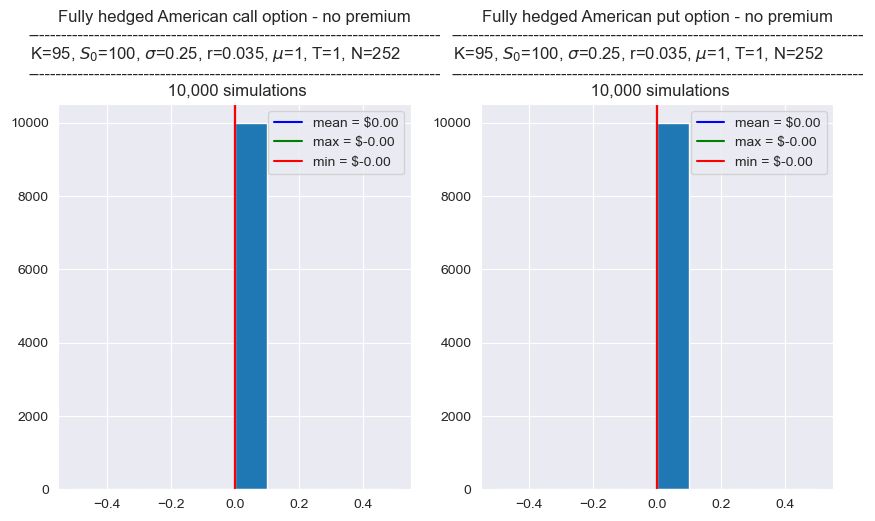

In [467]:
S0 = 100
K = 95
sigma = .25
r = 0.035
T = 1
N = 252
n_paths = 10_000
mu=1
num_hedges = 230

model = binomial_model(sigma, r, T, N)
profit = am_replicating_portfolio_profit(model,n_paths,S0,K,N,'call',premium=0,mu=mu)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10, 5))
ax1.hist(profit,bins=10)
ax1.set_title(f'Fully hedged American call option - no premium\n{'-'*75}\n K={K}, $S_0$={S0}, $\sigma$={sigma}, r={r}, $\mu$={mu}, T={T}, N={N}\
          \n{'-'*75}\n {n_paths:,} simulations')
ax1.axvline(np.mean(profit),c='b',label=f'mean = ${np.mean(profit):.2f}')
ax1.axvline(np.max(profit),c='g',label=f'max = ${np.max(profit):.2f}')
ax1.axvline(np.min(profit),c='r',label=f'min = ${np.min(profit):.2f}')
ax1.legend()

profit = am_replicating_portfolio_profit(model,n_paths,S0,K,N,'put',premium=0,mu=mu)
ax2.hist(profit,bins=10)
ax2.set_title(f'Fully hedged American put option - no premium\n{'-'*75}\n K={K}, $S_0$={S0}, $\sigma$={sigma}, r={r}, $\mu$={mu}, T={T}, N={N}\
          \n{'-'*75}\n {n_paths:,} simulations')  
ax2.axvline(np.mean(profit),c='b',label=f'mean = ${np.mean(profit):.2f}')
ax2.axvline(np.max(profit),c='g',label=f'max = ${np.max(profit):.2f}')
ax2.axvline(np.min(profit),c='r',label=f'min = ${np.min(profit):.2f}')
ax2.legend()
plt.show()

If we do not remove the excess cash, Y, from the portfolio we should expect that the *put options* should be profitable on average even with no premium so long as the holder is not optimally stopping.  We can test this easily and see that even with a downward drift there is excess cash when fully hedging:

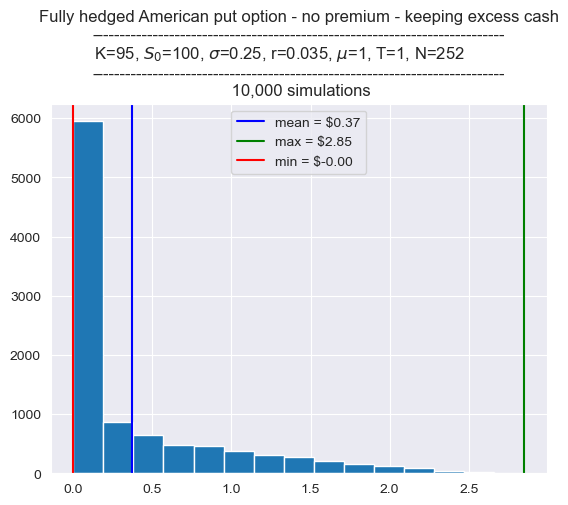

In [468]:
profit = am_replicating_portfolio_profit(model,n_paths,S0,K,N,'put',premium=0,mu=-0.1,Ymult=0)
plt.hist(profit,bins=15)
plt.title(f'Fully hedged American put option - no premium - keeping excess cash\n{'-'*75}\n K={K}, $S_0$={S0}, $\sigma$={sigma}, r={r}, $\mu$={mu}, T={T}, N={N}\
          \n{'-'*75}\n {n_paths:,} simulations')
plt.axvline(np.mean(profit),c='b',label=f'mean = ${np.mean(profit):.2f}')
plt.axvline(np.max(profit),c='g',label=f'max = ${np.max(profit):.2f}')
plt.axvline(np.min(profit),c='r',label=f'min = ${np.min(profit):.2f}')
plt.legend()
plt.show()

Now we want to explore varying levels of optimal stopping.

In [469]:
def am_replicating_portfolio_profit_stopping(model,n_paths,S0,K,num_hedges,option_type,stop='opt',premium=0.0,mu=0.0,Ymult=1):
        ''' 
        produces the american option replicating portfolio.  model is a binomial_model class.  all other variables are similar to previous appearances.
        Ymult = 0 means the Y's will be added to the portfolio i.e. if option is not optimally stopped the portfolio will be larger than the option.
        Ymult = 1 (default) is the exact replicating portfolio that matches the option value.
        stop = 'opt' by default, this means the option holder exercises optimally. other options are 'rand' for random stopping, and 0 < f < 1 where f is the fraction of paths optimally stopping.
        '''
        #parameters from the model
        r = model.r
        N = model.N
        T = model.T
        n_sims = n_paths
        samp = binomial_path_sample(n_paths,model,mu=mu)
        node_paths = samp.paths.copy()
        node_paths[:,1:] -= node_paths[:,:-1] - 1
        node_paths = np.cumsum(node_paths//2,axis=1)
        #variables to be used in the method
        dt = T/N
        
        init_put_price = am_put_option_tree(model,S0,K)[0][(0,0)]
        init_call_price = am_call_option_tree(model,S0,K)[0][(0,0)]
        #check if type was correctly chosen
        if option_type.upper() == 'CALL':
            delta_paths = am_delta_paths(model,samp.paths,S0,K,option_type)
            X = np.full(n_sims,init_call_price) + premium 
            stopping_tree = am_call_option_tree(model,S0,K)[1]
        elif option_type.upper() == 'PUT':
            delta_paths = am_delta_paths(model,samp.paths,S0,K,option_type)
            X = np.full(n_sims,init_put_price) + premium
            stopping_tree = am_put_option_tree(model,S0,K)[1]
        else:
            raise ValueError('keyword "option_type" must be either "call" or "put".')
        
        price_paths = samp.price(S0)
        Y = Y_paths(model,samp.paths,S0,K,option_type)

        if type(stop) == str and stop.upper() == 'OPT':
            stopping_paths = np.array([[int(stopping_tree[(n, node)]) for n, node in enumerate(path)] for path in node_paths])
            stopping_periods = np.argmax(stopping_paths,axis=1)
            stopping_periods[stopping_periods==0] = -1
            for i,path in enumerate(stopping_paths):    
                path[:stopping_periods[i]] = 1
                path[stopping_periods[i]:] = 0

        elif type(stop) == str and stop.upper() == 'RAND':
            stopping_paths = np.array([[int(stopping_tree[(n, node)]) for n, node in enumerate(path)] for path in node_paths])
            stopping_periods = np.random.randint(0,N+1,n_sims)
            stopping_periods[stopping_periods==0] = -1
            for i,path in enumerate(stopping_paths):    
                if K - price_paths[i,stopping_periods[i]] - init_put_price -premium > 0 and option_type.upper() == 'PUT':
                    path[:stopping_periods[i]] = 1
                    path[stopping_periods[i]:] = 0
                elif price_paths[i,stopping_periods[i]] - K - init_call_price-premium > 0 and option_type.upper() == 'CALL':
                    path[:stopping_periods[i]] = 1
                    path[stopping_periods[i]:] = 0
                else:
                    path[:] = 1
                    stopping_periods[i] = -1
        
        elif type(stop) == float and 0 <= stop <= 1:
            stopping_paths = np.array([[int(stopping_tree[(n, node)]) for n, node in enumerate(path)] for path in node_paths])
            stopping_periods = np.argmax(stopping_paths,axis=1)
            stopping_periods[stopping_periods==0] = -1
            for i,path in enumerate(stopping_paths):
                if np.random.binomial(1,stop):
                    path[:stopping_periods[i]] = 1
                    path[stopping_periods[i]:] = 0
                else:
                    path[:] = 1
                    stopping_periods[i] = -1.
                    
        else:
            raise ValueError('keyword "stop" must be one of the strings ("opt","rand") or a number in [0,1]')
        
        #creates an array of approx. evenly space time steps in the tree such that there are num_hedges steps.
        hedge_steps = [int(i) for i in np.array(list(range(N)))*N/num_hedges if int(i) <= N-1]
        hedge_steps.append(N)
        
        
        for i,step in enumerate(hedge_steps[:-1]):
            X *= np.exp(r*dt*(hedge_steps[i+1]-hedge_steps[i])*stopping_paths[:,step])
            X += (delta_paths[:,step]*(price_paths[:,step+1]-np.exp(r*dt*(hedge_steps[i+1]-hedge_steps[i]))*price_paths[:,step])\
                  - np.exp(r*T/N*(hedge_steps[i+1]-hedge_steps[i]))*(Ymult)*Y[:,step])*stopping_paths[:,step]
            
        #return stopping_paths,stopping_periods
        if option_type.upper() == 'CALL':
            call_payout = np.fmax(price_paths[range(n_sims),stopping_periods] - K,0.0)
            profit = np.around(np.exp(-r*T)*(X - call_payout),2)
            return profit
        
        if option_type.upper() == 'PUT':
            put_payout = np.fmax(K - price_paths[range(n_sims),stopping_periods],0.0)
            profit = np.around(np.exp(-r*T)*(X - put_payout),2)
            return profit

Below we consider various amounts of optimal stopping, in the simulation a path either stops optimally or it waits until expiration.  A more complicated model could be implemented where the holder stops at some time between the optimal time and expiration so long as the contract is in the money however that is beyond the scope of what I intend to show here.  From the chart below we see that we recreate the above mean ~$0.37 when there is no optimal stopping, and continue linearly down to $0.00 at maximal optimal stopping.

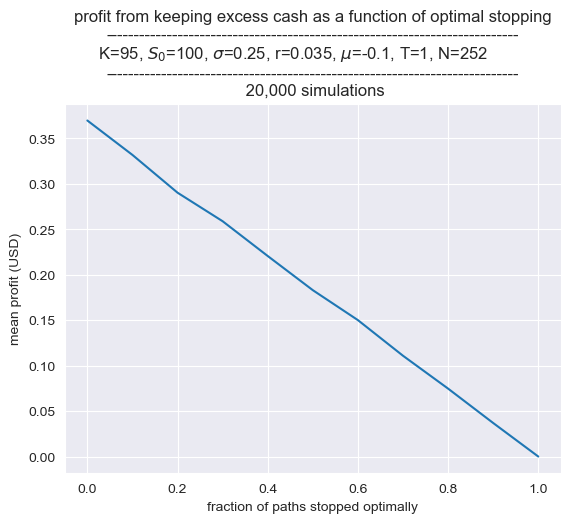

In [487]:
S0 = 100
K = 95
sigma = .25
r = 0.035
T = 1
N = 252
n_paths = 20_000
mu = -0.1

model = binomial_model(sigma, r, T, N)

profit = [np.mean(am_replicating_portfolio_profit_stopping(model,n_paths,S0,K,N,'put',mu=mu,Ymult=0,stop=float(f))) for f in np.linspace(0.,1.,11)]

plt.plot(np.linspace(0.,1.,11),profit)
plt.ylabel('mean profit (USD)')
plt.xlabel('fraction of paths stopped optimally')
plt.title(f'profit from keeping excess cash as a function of optimal stopping\n{'-'*75}\n K={K}, $S_0$={S0}, $\sigma$={sigma}, r={r}, $\mu$={mu}, T={T}, N={N}\
          \n{'-'*75}\n {n_paths:,} simulations')
plt.show()

Another scenario one might be interested in is what happens if the holder chooses to stop randomly so long as the inherent value of the option is positive.  This seems to be a somewhat realistic scenario when modeling unsophisticated options buyers and thus may be one of interest.

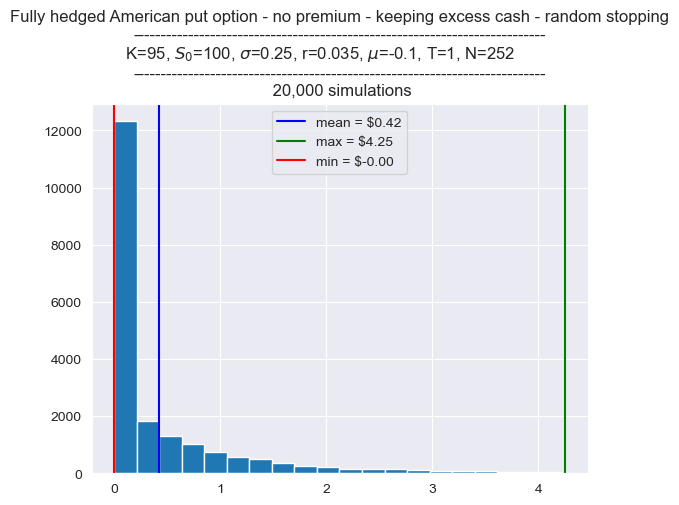

In [476]:
profit = am_replicating_portfolio_profit_stopping(model,n_paths,S0,K,N,'put',mu=mu,Ymult=0,stop='rand')
plt.hist(profit,bins=20)
plt.title(f'Fully hedged American put option - no premium - keeping excess cash - random stopping\n{'-'*75}\n K={K}, $S_0$={S0}, $\sigma$={sigma}, r={r}, $\mu$={mu}, T={T}, N={N}\
          \n{'-'*75}\n {n_paths:,} simulations')
plt.axvline(np.mean(profit),c='b',label=f'mean = ${np.mean(profit):.2f}')
plt.axvline(np.max(profit),c='g',label=f'max = ${np.max(profit):.2f}')
plt.axvline(np.min(profit),c='r',label=f'min = ${np.min(profit):.2f}')
plt.legend()
plt.show()


Note, all of the above cases were for perfect hedging.  With American options hedging becomes much more significant due to the lack of control over when the option holder will choose to exercise their right to buy or sell the stock.  Thus, lowering the number of hedges as we did in European options has a larger effect on the profit distribution, even with a premium.  Below, we see that even with 200 hedges the optimal stopping case is negative for the seller without a premium and the random stopper (the best case for the seller) barely breaks even.

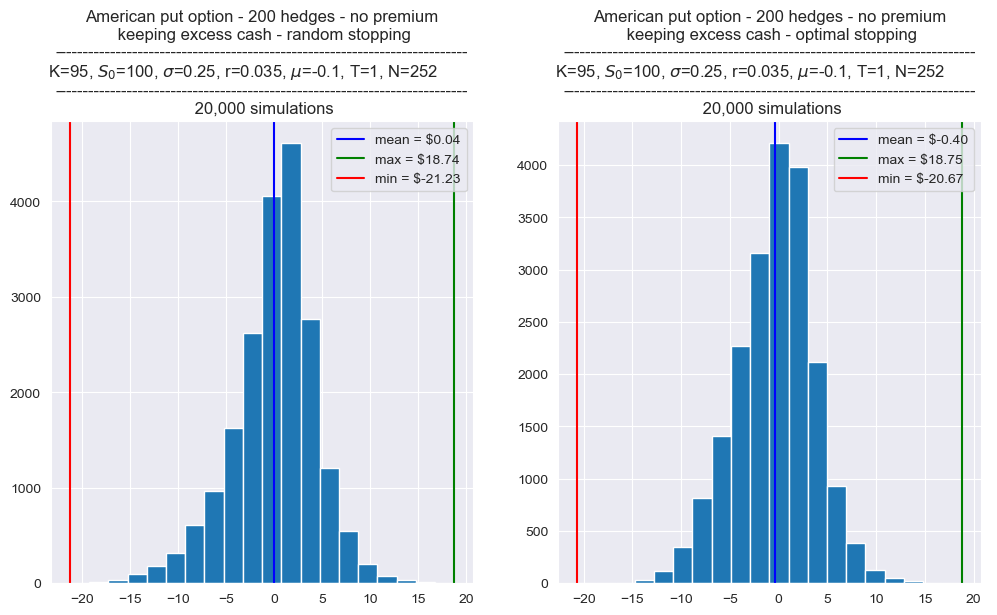

In [486]:
num_hedges = 200
prem = 0

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12, 6))


profit = am_replicating_portfolio_profit_stopping(model,n_paths,S0,K,num_hedges,'put',mu=mu,Ymult=0,stop='rand',premium=prem)
ax1.hist(profit,bins=20)
ax1.set_title(f'American put option - {num_hedges} hedges - no premium\n keeping excess cash - random stopping\n{'-'*75}\n K={K}, $S_0$={S0}, $\sigma$={sigma}, r={r}, $\mu$={mu}, T={T}, N={N}\
          \n{'-'*75}\n {n_paths:,} simulations')
ax1.axvline(np.mean(profit),c='b',label=f'mean = ${np.mean(profit):.2f}')
ax1.axvline(np.max(profit),c='g',label=f'max = ${np.max(profit):.2f}')
ax1.axvline(np.min(profit),c='r',label=f'min = ${np.min(profit):.2f}')
ax1.legend()

profit = am_replicating_portfolio_profit_stopping(model,n_paths,S0,K,num_hedges,'put',mu=mu,Ymult=0,stop='opt',premium=prem)
ax2.hist(profit,bins=20)
ax2.set_title(f'American put option - {num_hedges} hedges - no premium\n keeping excess cash - optimal stopping\n{'-'*75}\n K={K}, $S_0$={S0}, $\sigma$={sigma}, r={r}, $\mu$={mu}, T={T}, N={N}\
          \n{'-'*75}\n {n_paths:,} simulations')
ax2.axvline(np.mean(profit),c='b',label=f'mean = ${np.mean(profit):.2f}')
ax2.axvline(np.max(profit),c='g',label=f'max = ${np.max(profit):.2f}')
ax2.axvline(np.min(profit),c='r',label=f'min = ${np.min(profit):.2f}')
ax2.legend()
plt.show()